
Question 1
	Accuracy of predicting labels using SVM on 2020 dataset is 98.0 %

Question 2
	Confusion Matrix for 2020 stock dataset



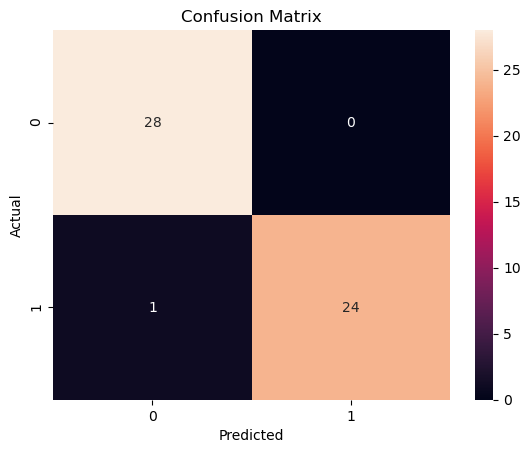


Question 3
	TPR of 2020 dataset is 100.0 TNR of 2020 dataset is 96.0 .

Question 4
	Accuracy of predicting labels using Gaussian SVM on 2020 dataset is 85.0 %.
Linear SVM accuracy is higher than Gaussian SVM.

Question 5
	Accuracy of predicting labels using Polynomial SVM of degree 2 on 2020 dataset is 96.0 %.
Linear SVM accuracy is higher than Gaussian SVM and Polynomial SVM

Question 6
	Using predicted labels from Linear SVM classifier, the trading strategy returns = 150.09 .Buy hold returns for the same dataset is 30.95 .The trading strategy gave much higher returns than using buy and hold strategy.


<ipython-input-1-323684c4a49b>:117: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  stock_agg2020_df = stock_agg2020_df.drop('label',1)


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix

##set default config
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', 12)
pd.set_option('display.expand_frame_repr', False)
pd.options.display.float_format = '{:,.2f}'.format

##set filenames
input_dir = os.getcwd()
root_dir = os.getcwd()

labels_file ='BAC_weekly_return_volatility_labels'
details_file = 'BAC_weekly_return_volatility_detailed'
labels_path_file = os.path.join(input_dir, labels_file+'.csv')
details_path_file = os.path.join(input_dir,details_file+'.csv')


try:
   labels_df = pd.read_csv(labels_path_file)
   details_df = pd.read_csv(details_path_file)
except Exception as e:
  print(e)
  print('Failed to read input files', labels_file)


## split dataframe into train and test
stock2019_df = labels_df[labels_df['Year'].isin([2019])]
stock2020_df = labels_df[labels_df['Year'].isin([2020])]

# Question 1 - Run Logistic on training 
X_train = stock2019_df[['mean_return','volatility']]
Y_train = stock2019_df[['label']]
X_test = stock2020_df[['mean_return','volatility']]
Y_test = stock2020_df[['label']]

# Apply SVM classifier to the split data frame
svm_classifier = svm.SVC( kernel ='linear')
clf = svm_classifier.fit(X_train, np.ravel(Y_train))
SVM_pred = clf.predict(X_test)

# Get the accuracy and append it to the dictionary
accuracy = np.mean(SVM_pred == np.ravel(Y_test))

# Question 1 - print accuracy for year 2
print('\nQuestion 1\n\tAccuracy of predicting labels using SVM on 2020 dataset is', round(accuracy,2)*100,'%')

# Question 2 - print confusion matrix
cm=confusion_matrix(np.ravel(Y_test),SVM_pred)
cm = pd.DataFrame(cm)
print('\nQuestion 2\n\tConfusion Matrix for 2020 stock dataset\n')
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Question 3 - calculate tpr and tnr
tp = cm[0][0]
tn = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]

tpr = 100*round(tp/(tp+fn),2)
tnr = 100*round(tn/(fp+tn),2)
print('\nQuestion 3\n\tTPR of 2020 dataset is',round(tpr,2),'TNR of 2020 dataset is',round(tnr,2),'.')

# Question 4 - Run Gaussian SVM
svm_classifier = svm.SVC( kernel ='rbf')
clf = svm_classifier.fit(X_train, np.ravel(Y_train))
SVM_gaussian_pred = clf.predict(X_test)

# Get the accuracy and append it to the dictionary
svm_gaussian_accuracy = np.mean(SVM_gaussian_pred == np.ravel(Y_test))

# print accuracy for year 2
print('\nQuestion 4\n\tAccuracy of predicting labels using Gaussian SVM on 2020 dataset is', round(svm_gaussian_accuracy,2)*100,'%.')
print("Linear SVM accuracy is higher than Gaussian SVM.")

# Question 5 - Run Polynomial SVM
svm_classifier = svm.SVC( kernel ='poly',degree = 2)
clf = svm_classifier.fit(X_train, np.ravel(Y_train))
SVM_poly_pred = clf.predict(X_test)

# Get the accuracy and append it to the dictionary
svm_poly_accuracy = np.mean(SVM_poly_pred == np.ravel(Y_test))

# print accuracy for year 2
print('\nQuestion 5\n\tAccuracy of predicting labels using Polynomial SVM of degree 2 on 2020 dataset is', round(svm_poly_accuracy,2)*100,'%.')
print("Linear SVM accuracy is higher than Gaussian SVM and Polynomial SVM")


# Question 6 calculate returns using predicted labels
pred_stock_df = labels_df.copy().reset_index()
pred_stock_df = details_df.merge(labels_df[['Year','Week_Number','label']], on= ['Year','Week_Number'], how = 'inner')
pred_stock_df = pred_stock_df[['Open','Adj Close','Year','Week_Number',\
            'mean_return','volatility','label']]

## copy Open and Adj Close prices from first and last day of each week
stock_agg_df = pred_stock_df.groupby(['Year','Week_Number']).agg({'Open':'first', 'Adj Close':'last', 'mean_return':'first', 'volatility':'first','label':'first'})

## calculate weekly returns
stock_agg_df['week_return'] = (stock_agg_df['Adj Close'] - stock_agg_df['Open'])/stock_agg_df['Open']

stock_agg_df = stock_agg_df.reset_index()

## split dataframe for year 2020
stock_agg2020_df = stock_agg_df[stock_agg_df['Year'].isin([2020])]

## attach newly predicted labels
stock_agg2020_df = stock_agg2020_df.drop('label',1)
stock_agg2020_df['label'] = SVM_pred


def my_returns(data):
    ## create new col for cumulative returns based on predicted labels
      new_col = 'my_return'
      #data[new_col] = '100'
      previous_day = 100.00
      ## if label = +, then return = Open/principal*(Adj Close) else its prev principal
      ## if label is - then return = prev_day
      for row in data.index:
          if data['label'][row] == '+':
             investment_return = float(previous_day)*(1+float(data['week_return'][row]))
          else:
             investment_return = float(previous_day)
          data.loc[row,new_col] = investment_return 
          previous_day = data[new_col][row]
      data[new_col] = pd.to_numeric(data[new_col],errors = 'coerce')
      return round(investment_return,2)

my_final_returns = my_returns(stock_agg2020_df)

def buy_hold_return(data):
    ## create new data col
    new_col = 'Buy_Hold'
    ## set default 
    data[new_col] = '100'
    previous_day = 100.00
    ## for each row calculate net_return = prev_day(1+ curr_day return)
    for row in data.index:
        investment_return = float(previous_day)*(1+ float(data['week_return'][row]))
        data.loc[row,new_col] = investment_return 
        previous_day = data[new_col][row]
        data[new_col] = pd.to_numeric(data[new_col],errors = 'coerce')  
    return round(investment_return, 2)    

buy_hold_returns = buy_hold_return(stock_agg2020_df)

print('\nQuestion 6\n\tUsing predicted labels from Linear SVM classifier, the trading strategy returns =', my_final_returns,'.Buy hold returns for the same dataset is', buy_hold_returns,'.The trading strategy gave much higher returns than using buy and hold strategy.' )
